# Analysing the models

In this notebook we work under the Normal white noise assumption 

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

The goal in this notebook is to investigate how dynamic containment can be used to complement power grid when frequency in the grid changes.

We assume three different battery powers: 2 MW, 5 MW and 10 MW

First, assming white noise, following the previous notebook, we can calculate the expected rate of change of the charge for all three cases

In [2]:
service_powers = [2, 5, 10]

Let's use the data for our variances

In [3]:
freq_table = utils.read_and_clean()

In [4]:
dcdt = np.array([
    utils.calc_gaussian_slope(freq_table.delta_freq.std(), sp)
    for sp in service_powers
])

In [5]:
dcdt

array([-3.23914437e-07, -8.09786093e-07, -1.61958050e-06])

From these slopes, we can calculate how long it would take to use up a full battery (if we chose to start with one!)

In [6]:
-4.0/(dcdt*(3600.0 * 24.0))

array([142.92754806,  57.17101922,  28.58536289])

That is, 143 days for the 2 MW battery, 57 days for the 5 MW battery and 29 days for the 10 MW battery.

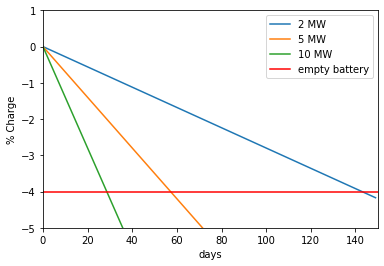

In [7]:
days = np.arange(150)
plt.plot(days, days * (dcdt[0]*(3600.0 * 24.0)), label="2 MW")
plt.plot(days, days * (dcdt[1]*(3600.0 * 24.0)), label="5 MW")
plt.plot(days, days * (dcdt[2]*(3600.0 * 24.0)), label="10 MW")
plt.axhline(-4.0, color='red', label="empty battery")
plt.ylabel("% Charge")
plt.xlabel("days")
plt.xlim([0, 150])
plt.ylim([-5, 1])
plt.legend()


In [8]:
real_space_cov = utils.temporal_covariance(freq_table, max_sep=18001, step=50)

  0%|          | 0/361 [00:00<?, ?it/s]

In [9]:
# first makes sure I generate enough data (18000s = 5hrs)

num_blocks = np.ceil(150 * 24 * 3600 / (18000.0))

# This is the number of realisations. I have tested at higher values, but takes longer to run
nreals = 10

time_step = 10
num_samples = [nreals, int(num_blocks)]

This takes a while, as we need to process the sims for three service powers! Note, we create independent simuations for each case

In [13]:
reals = {}

summaries = {}

num_seconds = 150 * 24 * 3600

for p in service_powers:
    
    samples = utils.simulate_grf_using_cov(real_space_cov, max_time=18000, time_step=time_step, num_samples=num_samples)
    
    samples = [s.flatten()[:num_seconds] for s in samples]
    
    new_samples = utils.interp_samples(samples, max_time=num_seconds, step_samples=time_step)
    
    count = 0
    
    reals[p] = {}

    for s in tqdm(new_samples):
        
        df = pd.DataFrame()
        df["date"] = range(len(s))
        df["delta_freq"] = s
        df = utils.add_charge_info(df, p)

        reals[p][count] = df
    
        count+=1
        
    summaries[p] = reals[p][0].copy()
    summaries[p]['culm_charge'] = 0.0
    summaries[p]['culm_charge_sq'] = 0.0

    for s in reals[p]:
    
        summaries[p]['culm_charge'] += reals[p][s]['culm_charge']
        summaries[p]['culm_charge_sq'] += reals[p][s]['culm_charge']**2.0

    summaries[p]['culm_charge'] = summaries[p]['culm_charge'] / len(reals[p])
    
    summaries[p]['var_charge'] = (
        summaries[p]['culm_charge_sq'] / (len(reals[p]) - 1)
        - summaries[p]['culm_charge']**2.0 * len(reals[p]) / (len(reals[p]) - 1)
    )
    
    summaries[p]['std_charge'] = np.sqrt(summaries[p]['var_charge'])
    

creating covariance
creating samples


  0%|          | 0/10 [00:00<?, ?it/s]

creating covariance
creating samples


  0%|          | 0/10 [00:00<?, ?it/s]

creating covariance
creating samples


  0%|          | 0/10 [00:00<?, ?it/s]

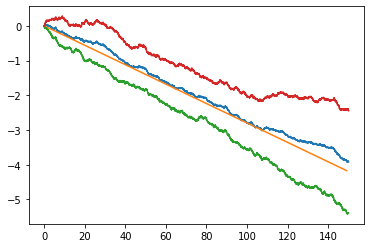

In [109]:
p = 2

plt.plot(summaries[p].date/(3600.0 * 24.0), summaries[p].culm_charge)
plt.plot(days, days * (dcdt[service_powers.index(p)]*(3600.0 * 24.0)), label=f"{p} MW")
plt.plot(summaries[p].date/(3600.0 * 24.0), summaries[p].culm_charge-summaries[p].std_charge)
plt.plot(summaries[p].date/(3600.0 * 24.0), summaries[p].culm_charge+summaries[p].std_charge)

In [110]:
E0 = (summaries[p].culm_charge+5*summaries[p].std_charge).max()

In [111]:
E0

3.809903155805867

In [112]:
mean_date = (0-4)/(dcdt[service_powers.index(p)])

dates = []

for i in range(nreals):
    t = reals[p][i].where(-E0 + reals[p][i].culm_charge>-4)
    dates.append(t.date.dropna().max())

The mean date isn't the date of the mean!!!

In [113]:
print(f"average date to reach zero given a safe start is {np.round(np.mean(dates)/(24 * 3600), 2)} +/- {np.round(np.std(dates)/(24 * 3600), 2)} days")

average date to reach zero given a safe start is 20.4 +/- 14.65 days


In [114]:
mean_date = (E0-4)/(dcdt[service_powers.index(p)])

In [115]:
mean_date/(24 * 3600)

6.792518958516646